In [1]:
import boto3
import sagemaker
import os
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.pytorch import PyTorch

In [2]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

bucket = sagemaker_session.default_bucket()

container = get_image_uri(boto3.Session().region_name, 'image-classification')

In [6]:
prefix = 'capstone_data'
s3_dataPath = 's3://{}/{}'.format(bucket, prefix)

train_location = os.path.join(s3_dataPath, 'train')
val_location = os.path.join(s3_dataPath, 'val')
test_location = os.path.join(s3_dataPath, 'test')

s3_lstPath = 's3://{}/lst_files'.format(bucket)

train_lst = os.path.join(s3_lstPath, 'training.lst')
val_lst = os.path.join(s3_lstPath, 'validation.lst')
test_lst = os.path.join(s3_lstPath, 'testing.lst')

In [4]:
train_location

's3://sagemaker-us-east-2-991170486756/capstone_data/train'

# AWS Image Classifier

We will be using the HyperParameter Tuning system of AWS, so this process is more complicated than usual. However, it will yield the best results by finding the best model out of a random set of models.

## Constructing the AWS Estimator

In [6]:
ResNet = sagemaker.estimator.Estimator(role=role, 
                                       sagemaker_session=sagemaker_session, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.p2.xlarge',
                                       output_path="s3://{}/{}/output".format(bucket, 'ResNet'), 
                                       image_name=container)

## Hyperparamaters

You can read the documentation for all the Hyperparameters of the Image Classification Algorithm <a href=https://docs.aws.amazon.com/sagemaker/latest/dg/IC-Hyperparameter.html>here</a>.<br>
<ul>
    <li><b>(Required) num_classes</b>: This is the number of output classes for the new dataset. Ours will be 2 for normal or pneumonia</li>
    <li><b>(Required) num_training_samples</b>: This is the total number of training samples. The training set has 5,216 images in total.</li>
    <li><b>num_layers</b>: The number of layers (depth) for the network. We use will 152 layers</li>
    <li><b>image_shape</b>: The input image dimensions,'num_channels, height, width', for the network. It should be no larger than the actual image size. The number of channels should be same as the actual image.</li>
    <li><b>mini_batch_size</b>: The number of training samples used for each mini batch. In distributed training, the number of training samples used per batch will be N * mini_batch_size where N is the number of hosts on which training is run.</li>
    <li><b>epochs</b>: Number of training epochs.</li>
    <li><b>learning_rate</b>: Learning rate for training.</li>
    <li><b>precision_dtype</b>: Training datatype precision (default: float32). If set to 'float16', the training will be done in mixed_precision mode and will be faster than float32 mode</li>
</ul>

In [7]:
ResNet.set_hyperparameters(num_layers=152, #152 layers for ResNet-152
                           image_shape= "3,224,224", #The dimensions of our cleaned images
                           mini_batch_size=32, #Each batch will have 64 images
                           epochs=10, #10 epochs or training iterations through the training set
                           learning_rate = 0.01, #Learning rate used for the optimizer of the model which is sgd
                           precision_dtype = 'float32',
                           num_training_samples=5215,
                           num_classes=2
                          )

## Hyperparameter Tuning
I will tune the model by some of the embedded Image Classifier hyperparameters, you can read more <a href=https://docs.aws.amazon.com/sagemaker/latest/dg/IC-tuning.html>here</a>. The goal would be to select the best model that is chosen by the highest validation accuracy.

In [14]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner, CategoricalParameter

ResNet_hyperparameter_tuner = HyperparameterTuner(estimator=ResNet, 
                                                  objective_metric_name='validation:accuracy', 
                                                  objective_type='Maximize', 
                                                  max_jobs=5, #Going to run 20 different models
                                                  max_parallel_jobs=1, #Going to train 3 models at the same time
                                                  hyperparameter_ranges={
                                                      #'mini_batch_size':IntegerParameter(64, 128),
                                                      'learning_rate':ContinuousParameter(0.01, 0.1, scaling_type='Logarithmic'),
                                                      'optimizer': CategoricalParameter(['sgd', 'adam', 
                                                                                              'rmsprop', 'nag'])
                                                  })

## Load the data

In [7]:
train_data = sagemaker.session.s3_input(train_location, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(val_location, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')
testing_data = sagemaker.session.s3_input(test_location, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')

train_data_lst = sagemaker.session.s3_input(train_lst, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data_lst = sagemaker.session.s3_input(val_lst, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')
test_data_lst = sagemaker.session.s3_input(test_lst, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')

data_channels = {'train':train_data, 'validation': validation_data, 
                 'train_lst':train_data_lst, 'validation_lst':validation_data_lst}
    

## Fitting the Hyperparameter Tuning job

Here is where AWS will train multiple training jobs to find the best model out of a number of models.

In [17]:
ResNet_hyperparameter_tuner.fit(data_channels)

In [ ]:
ResNet_hyperparameter_tuner.wait()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

After training numerous models, I will find the one that provided the best training job. <br><br>
Which is here below:

In [27]:
ResNet_hyperparameter_tuner.best_training_job()

'image-classification-200112-2133-002-5c8e0b5a'

I am going to create an AWS <a href=https://sagemaker.readthedocs.io/en/stable/estimators.html>Estimator</a> that uses the training job's model artifacts from above

In [9]:
aws_estimator = sagemaker.estimator.Estimator.attach(training_job_name='image-classification-200112-2133-002-5c8e0b5a')

2020-01-12 23:14:27 Starting - Preparing the instances for training
2020-01-12 23:14:27 Downloading - Downloading input data
2020-01-12 23:14:27 Training - Training image download completed. Training in progress.
2020-01-12 23:14:27 Uploading - Uploading generated training model
2020-01-12 23:14:27 Completed - Training job completedDocker entrypoint called with argument(s): train
[01/12/2020 22:28:25 INFO 139726532032320] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}
[01/12/2020 22:28:25 INFO 139726532032320] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {u

[01/12/2020 23:04:11 INFO 139726532032320] Epoch[7] Train-accuracy=0.958333
[01/12/2020 23:04:11 INFO 139726532032320] Epoch[7] Time cost=264.585
[01/12/2020 23:04:13 INFO 139726532032320] Epoch[7] Validation-accuracy=0.625000
[01/12/2020 23:04:47 INFO 139726532032320] Epoch[8] Batch [20]#011Speed: 18.793 samples/sec#011accuracy=0.950893
[01/12/2020 23:05:20 INFO 139726532032320] Epoch[8] Batch [40]#011Speed: 19.178 samples/sec#011accuracy=0.959604
[01/12/2020 23:05:53 INFO 139726532032320] Epoch[8] Batch [60]#011Speed: 19.305 samples/sec#011accuracy=0.961578
[01/12/2020 23:06:26 INFO 139726532032320] Epoch[8] Batch [80]#011Speed: 19.362 samples/sec#011accuracy=0.962577
[01/12/2020 23:06:58 INFO 139726532032320] Epoch[8] Batch [100]#011Speed: 19.405 samples/sec#011accuracy=0.958230
[01/12/2020 23:07:31 INFO 139726532032320] Epoch[8] Batch [120]#011Speed: 19.439 samples/sec#011accuracy=0.955579
[01/12/2020 23:08:04 INFO 139726532032320] Epoch[8] Batch [140]#011Speed: 19.466 samples/sec#

## Deploying the AWS Estimator

In [14]:
aws_classifier = aws_estimator.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m4.xlarge')

--------------------------------------------------------------------------!

## Testing the EndPoint

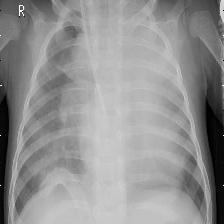

In [22]:
file_name = os.path.join(os.getcwd(), 'clean_data/test/PNEUMONIA/test_PNEUMONIA_100.jpeg')
from IPython.display import Image
Image(file_name)

In [23]:
import json
import numpy as np

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
    
aws_classifier.content_type = 'application/x-image'
result = json.loads(aws_classifier.predict(payload))

In [24]:
index = np.argmax(result)

classes = ['Normal', 'Pneumonia']
print('predicted class:', classes[index])
print('Probability:', result[index])

predicted class: Pneumonia
Probability: 0.9999531507492065


## Testing AWS Model

<b>Remember the classes:</b><br>
<ul>
    <li>Normal Images is 0</li>
    <li>Pneumonia Images is 1</li>
    </ul>

In [29]:
import glob
from pathlib import Path
data_dir = Path(os.path.join(os.getcwd(), 'chest_xray'))
test_NORMAL_dir = data_dir / 'test' / 'NORMAL'
test_PNEUMONIA_dir = data_dir / 'test' / 'PNEUMONIA'

In [30]:
test_NORMAL_images = list(test_NORMAL_dir.glob('*.jpeg'))
test_PNEUMONIA_images = list(test_PNEUMONIA_dir.glob('*.jpeg'))

In [34]:
from sklearn.metrics import roc_auc_score, accuracy_score
aws_classifier.content_type = 'application/x-image'

y_preds = []
y_actual = []
for normal_image in test_NORMAL_images:
    with open(normal_image, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)
        
    result = json.loads(aws_classifier.predict(payload))
    
    predicted_class = np.argmax(result)#This provides the index that has the greatest number which signifies the predicted class
    
    y_preds.append(predicted_class)
    y_actual.append(0)#The actual class is 0 since 0 signifies that it is a normal image
    
for pneumonia_image in test_PNEUMONIA_images:
    with open(pneumonia_image, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)
        
    result = json.loads(aws_classifier.predict(payload))
    
    predicted_class = np.argmax(result)#This provides the index that has the greatest number which signifies the predicted class
    
    y_preds.append(predicted_class)
    y_actual.append(1)#The actual class is 1 since 1 signifies that it is an image with Pneumonia
    
print(len(y_preds))
print(len(y_actual))
    
y_preds = np.array(y_preds)
y_actual = np.array(y_actual)


tp = np.logical_and(y_actual, y_preds).sum()
fp = np.logical_and(1-y_actual, y_preds).sum()
tn = np.logical_and(1-y_actual, 1-y_preds).sum()
fn = np.logical_and(y_actual, 1-y_preds).sum()
    
recall = tp / (tp + fn)
precision = tp / (tp + fp)
    
print("\nTrue Positives:", tp)
print('False Positives:', fp)
print('True Negatives:', tn)
print('False Negatives:', fn)

print('\nAccuracy:', accuracy_score(y_pred=y_preds, y_true=y_actual))
print('Recall:', recall)
print('Precision:', precision)
print('AUC SCORE:', roc_auc_score(y_true=y_actual, y_score=y_preds))

624
624

True Positives: 379
False Positives: 81
True Negatives: 153
False Negatives: 11

Accuracy: 0.8525641025641025
Recall: 0.9717948717948718
Precision: 0.8239130434782609
AUC SCORE: 0.8128205128205128


### AWS Model <br>

True Positives: 379<br>
False Positives: 81<br>
True Negatives: 153<br>
False Negatives: 11<br>

AUC Score: 0.8128205128205128 (Pretty good)

# Constucting my Convolutional Neural Network

I will use the S3 training and validation locations to fit the estimator

In [18]:
my_estimator = PyTorch(entry_point='TrainandTest.py',
                    source_dir='cnn_source', 
                    role=role, 
                    sagemaker_session=sagemaker_session, 
                    train_instance_count=1, 
                    train_instance_type='ml.p2.xlarge', 
                    framework_version='1.3.1',
                    hyperparameters={'epochs':20, 'learning_rate':0.05})

In [5]:
print(train_location)
print(val_location)
print(test_location)

s3://sagemaker-us-east-2-991170486756/capstone_data/train
s3://sagemaker-us-east-2-991170486756/capstone_data/val
s3://sagemaker-us-east-2-991170486756/capstone_data/test


In [19]:
my_estimator.fit({'train':train_location, 'validation':val_location, 'test':test_location}, logs=True)

2020-01-19 05:47:09 Starting - Starting the training job...
2020-01-19 05:47:38 Starting - Launching requested ML instances.........
2020-01-19 05:49:00 Starting - Preparing the instances for training............
2020-01-19 05:50:41 Downloading - Downloading input data...
2020-01-19 05:51:40 Training - Downloading the training image.........
2020-01-19 05:52:54 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-01-19 05:52:55,533 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-01-19 05:52:55,557 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-01-19 05:52:55,557 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-01-19 05:52:55,809 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.p


2020-01-19 06:04:18 Uploading - Uploading generated training model
2020-01-19 06:07:46 Completed - Training job completed
Training seconds: 1025
Billable seconds: 1025


### First Model <br>
Epochs: 20
Learning Rate: 0.05

True Positives: 377
False Positives: 96
True Negatives: 138
False Negatives: 13

AUC Score: 0.7782051282051282 (It is okay)

I will create two other PyTorch training job, but the learning rate is 0.1 and 0.01

## Second and Third Training Job

In [14]:
my_estimator2 = PyTorch(entry_point='TrainandTest.py',
                    source_dir='cnn_source', 
                    role=role, 
                    sagemaker_session=sagemaker_session, 
                    train_instance_count=1, 
                    train_instance_type='ml.p2.xlarge', 
                    framework_version='1.3.1',
                    hyperparameters={'epochs':20, 'learning_rate':0.1})

my_estimator3 = PyTorch(entry_point='TrainandTest.py',
                    source_dir='cnn_source', 
                    role=role, 
                    sagemaker_session=sagemaker_session, 
                    train_instance_count=1, 
                    train_instance_type='ml.p2.xlarge', 
                    framework_version='1.3.1',
                    hyperparameters={'epochs':20, 'learning_rate':0.01})

In [15]:
my_estimator2.fit({'train':train_location, 'validation':val_location, 'test':test_location}, logs=True)

2020-01-19 04:53:25 Starting - Starting the training job...
2020-01-19 04:53:26 Starting - Launching requested ML instances...
2020-01-19 04:54:22 Starting - Preparing the instances for training.........
2020-01-19 04:55:43 Downloading - Downloading input data......
2020-01-19 04:56:34 Training - Downloading the training image.........
2020-01-19 04:58:13 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-01-19 04:58:14,839 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-01-19 04:58:14,866 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-01-19 04:58:17,899 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-01-19 04:58:18,178 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2020


2020-01-19 05:10:06 Uploading - Uploading generated training model
2020-01-19 05:13:29 Completed - Training job completed
Training seconds: 1066
Billable seconds: 1066


In [16]:
my_estimator3.fit({'train':train_location, 'validation':val_location, 'test':test_location}, logs=True)

2020-01-19 05:20:14 Starting - Starting the training job...
2020-01-19 05:20:16 Starting - Launching requested ML instances...
2020-01-19 05:21:10 Starting - Preparing the instances for training............
2020-01-19 05:22:49 Downloading - Downloading input data......
2020-01-19 05:24:12 Training - Downloading the training image.......bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-01-19 05:25:19,065 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-01-19 05:25:19,090 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-01-19 05:25:22,120 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-01-19 05:25:22,405 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2020-01-19 05:25:22,405 sagemaker-containers INFO     Generating setup.cfg
2020-01-19 05:25


2020-01-19 05:36:39 Uploading - Uploading generated training model
2020-01-19 05:40:07 Completed - Training job completed
Training seconds: 1038
Billable seconds: 1038


### Second Model <br>
Epochs: 20<br>
Learning Rate: 0.1<br>

True Positives: 390<br>
False Positives: 197<br>
True Negatives: 37<br>
False Negatives: 0<br>

AUC Score: 0.579059829059829 (Not that good)


### Third Model <br>
Epochs: 20<br>
Learning Rate: 0.01<br>

True Positives: 390<br>
False Positives: 234<br>
True Negatives: 0<br>
False Negatives: 0<br>

AUC Score: 0.5 (Very bad because it seems that the learning rate was too small to backpropogate effeciently)

In [9]:
my_estimator4 = PyTorch(entry_point='TrainandTest.py',
                    source_dir='cnn_source', 
                    role=role, 
                    sagemaker_session=sagemaker_session, 
                    train_instance_count=1, 
                    train_instance_type='ml.p2.xlarge', 
                    framework_version='1.3.1',
                    hyperparameters={'epochs':20, 'learning_rate':0.045})

In [10]:
my_estimator4.fit({'train':train_location, 'validation':val_location, 'test':test_location}, logs=True)

2020-01-19 08:01:36 Starting - Starting the training job...
2020-01-19 08:01:38 Starting - Launching requested ML instances...
2020-01-19 08:02:33 Starting - Preparing the instances for training.........
2020-01-19 08:03:59 Downloading - Downloading input data......
2020-01-19 08:05:06 Training - Downloading the training image.........
2020-01-19 08:06:32 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-01-19 08:06:33,657 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-01-19 08:06:33,682 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-01-19 08:06:36,800 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-01-19 08:06:37,091 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
202


2020-01-19 08:21:37 Completed - Training job completed
Training seconds: 1058
Billable seconds: 1058


### Fourth Model <br>
Epochs: 20<br>
Learning Rate: 0.045<br>

True Positives: 370<br>
False Positives: 73<br>
True Negatives: 161<br>
False Negatives: 20<br>

AUC Score: 0.8183760683760684 (Better)

In [11]:
my_estimator5 = PyTorch(entry_point='TrainandTest.py',
                    source_dir='cnn_source', 
                    role=role, 
                    sagemaker_session=sagemaker_session, 
                    train_instance_count=1, 
                    train_instance_type='ml.p2.xlarge', 
                    framework_version='1.3.1',
                    hyperparameters={'epochs':20, 'learning_rate':0.04})

In [12]:
my_estimator5.fit({'train':train_location, 'validation':val_location, 'test':test_location}, logs=True)

2020-01-19 08:25:49 Starting - Starting the training job...
2020-01-19 08:25:51 Starting - Launching requested ML instances...
2020-01-19 08:26:46 Starting - Preparing the instances for training............
2020-01-19 08:28:40 Downloading - Downloading input data......
2020-01-19 08:29:35 Training - Downloading the training image......
2020-01-19 08:30:40 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-01-19 08:30:41,908 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-01-19 08:30:41,938 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-01-19 08:30:41,939 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-01-19 08:30:42,226 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2020


2020-01-19 08:42:12 Uploading - Uploading generated training model
2020-01-19 08:45:56 Completed - Training job completed
Training seconds: 1036
Billable seconds: 1036


### Fifth Model <br>
Epochs: 20<br>
Learning Rate: 0.04<br>

True Positives: 385<br>
False Positives: 145<br>
True Negatives: 89<br>
False Negatives: 5<br>

AUC Score: 0.6837606837606838 (Worse)

## Choosing best model

The fourth estimator of my own CNN with a learning rate of 0.045. It had the highest AUC Score of 0.8183760683760684.<br>
The name of the training job is 'pytorch-training-2020-01-19-08-01-36-460'

# VGG-16 model
Read more <a href=https://arxiv.org/pdf/1409.1556.pdf>here</a>.

In [38]:
vgg_estimator = PyTorch(entry_point='TrainandTest.py',
                    source_dir='vgg_source', 
                    role=role, 
                    sagemaker_session=sagemaker_session, 
                    train_instance_count=1, 
                    train_instance_type='ml.p2.xlarge', 
                    framework_version='1.3.1',
                    hyperparameters={'epochs':20, 'learning_rate':0.1})

In [39]:
vgg_estimator.fit({'train':train_location, 'validation':val_location, 'test':test_location}, logs=True)

2020-01-19 23:48:34 Starting - Preparing the instances for training
2020-01-19 23:48:34 Downloading - Downloading input data
2020-01-19 23:48:34 Training - Training image download completed. Training in progress.
2020-01-19 23:48:34 Uploading - Uploading generated training model
2020-01-19 23:48:34 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-01-19 22:57:43,371 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-01-19 22:57:43,395 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-01-19 22:57:46,423 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-01-19 22:57:46,727 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2020-01-19 22:57:46,727 sagemaker-containers INFO     Generating setup.cfg
2020-01-19 22:57:46,

### First VGG-16 Model <br>
Epochs: 20<br>
Learning Rate: 0.1<br>

True Positives: 389<br>
False Positives: 146<br>
True Negatives: 88<br>
False Negatives: 1<br>

AUC Score: 0.6867521367521368 (Not good)

In [40]:
vgg_estimator2 = PyTorch(entry_point='TrainandTest.py',
                    source_dir='vgg_source', 
                    role=role, 
                    sagemaker_session=sagemaker_session, 
                    train_instance_count=1, 
                    train_instance_type='ml.p2.xlarge', 
                    framework_version='1.3.1',
                    hyperparameters={'epochs':20, 'learning_rate':0.05})

In [41]:
vgg_estimator2.fit({'train':train_location, 'validation':val_location, 'test':test_location}, logs=True)

2020-01-20 23:41:50 Starting - Starting the training job...
2020-01-20 23:41:52 Starting - Launching requested ML instances...
2020-01-20 23:42:49 Starting - Preparing the instances for training............
2020-01-20 23:44:47 Downloading - Downloading input data......
2020-01-20 23:45:40 Training - Downloading the training image......
2020-01-20 23:46:45 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-01-20 23:46:46,239 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-01-20 23:46:46,264 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-01-20 23:46:46,265 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-01-20 23:46:46,530 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
202


2020-01-21 00:34:20 Uploading - Uploading generated training model/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
[2020-01-20 23:46:56.231 algo-1:44 INFO hook.py:151] tensorboard_dir has not been set for the hook. SMDebug will not be exporting tensorboard summaries.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
[2020-01-20 23:46:56.231 algo-1:44 INFO hook.py:196] Saving to /opt/ml/output/tensors
[2020-01-20 23:46:56.232 algo-1:44 INFO hook.py:325] Monitoring the collections: scalars, losses
Epoch: 1 #011Training Loss: 0.596083 #011Validation Loss: 0.825511
Validation loss decreased (inf --> 0.825511).  Saving model ...
Epoch: 2 #011Training Loss: 0.562854 #011Validation Loss: 0.745037
Validation loss decreased (0.825511 --> 0.745037).  Saving model ...
Epoc

### Second VGG-16 Model <br>
Epochs: 20<br>
Learning Rate: 0.05<br>

True Positives: 389<br>
False Positives: 128<br>
True Negatives: 106<br>
False Negatives: 1<br>

AUC Score: 0.7252136752136752 (Better)

In [42]:
vgg_estimator3 = PyTorch(entry_point='TrainandTest.py',
                    source_dir='vgg_source', 
                    role=role, 
                    sagemaker_session=sagemaker_session, 
                    train_instance_count=1, 
                    train_instance_type='ml.p2.xlarge', 
                    framework_version='1.3.1',
                    hyperparameters={'epochs':20, 'learning_rate':0.01})

In [44]:
vgg_estimator3.fit({'train':train_location, 'validation':val_location, 'test':test_location}, logs=True)

2020-01-21 00:37:00 Starting - Starting the training job...
2020-01-21 00:37:01 Starting - Launching requested ML instances...
2020-01-21 00:37:58 Starting - Preparing the instances for training............
2020-01-21 00:39:33 Downloading - Downloading input data.........
2020-01-21 00:41:03 Training - Downloading the training image.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-01-21 00:42:09,368 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-01-21 00:42:09,396 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-01-21 00:42:12,432 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-01-21 00:42:12,824 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2020-01-21 00:42:12,824 sagemaker-containers INFO     Generating setup.cfg
2020-01-21 00:4


2020-01-21 01:29:01 Uploading - Uploading generated training model/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
[2020-01-21 00:42:24.612 algo-1:44 INFO hook.py:151] tensorboard_dir has not been set for the hook. SMDebug will not be exporting tensorboard summaries.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
[2020-01-21 00:42:24.612 algo-1:44 INFO hook.py:196] Saving to /opt/ml/output/tensors
[2020-01-21 00:42:24.613 algo-1:44 INFO hook.py:325] Monitoring the collections: losses, scalars
Epoch: 1 #011Training Loss: 0.661753 #011Validation Loss: 0.700790
Validation loss decreased (inf --> 0.700790).  Saving model ...
Epoch: 2 #011Training Loss: 0.628231 #011Validation Loss: 0.714947
Epoch: 3 #011Training Loss: 0.605406 #011Validation Loss: 0.741168
Epoch:

### Third VGG-16 Model <br>
Epochs: 20<br>
Learning Rate: 0.01<br>

True Positives: 386<br>
False Positives: 147<br>
True Negatives: 87<br>
False Negatives: 4<br>

AUC Score: 0.6807692307692308 (Not so good)

In [46]:
vgg_estimator4 = PyTorch(entry_point='TrainandTest.py',
                    source_dir='vgg_source', 
                    role=role, 
                    sagemaker_session=sagemaker_session, 
                    train_instance_count=1, 
                    train_instance_type='ml.p2.8xlarge', 
                    framework_version='1.3.1',
                    hyperparameters={'epochs':20, 'learning_rate':0.065})

In [48]:
vgg_estimator4.fit({'train':train_location, 'validation':val_location, 'test':test_location}, logs=True)

2020-01-21 01:34:52 Starting - Starting the training job...
2020-01-21 01:34:53 Starting - Launching requested ML instances.........
2020-01-21 01:36:49 Starting - Preparing the instances for training.........
2020-01-21 01:38:23 Downloading - Downloading input data......
2020-01-21 01:39:23 Training - Downloading the training image......
2020-01-21 01:40:11 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-01-21 01:40:12,938 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-01-21 01:40:13,020 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-01-21 01:40:16,045 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-01-21 01:40:16,334 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2


2020-01-21 02:27:18 Uploading - Uploading generated training model/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
[2020-01-21 01:40:26.921 algo-1:72 INFO hook.py:151] tensorboard_dir has not been set for the hook. SMDebug will not be exporting tensorboard summaries.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
[2020-01-21 01:40:26.921 algo-1:72 INFO hook.py:196] Saving to /opt/ml/output/tensors
[2020-01-21 01:40:26.922 algo-1:72 INFO hook.py:325] Monitoring the collections: losses, scalars
Epoch: 1 #011Training Loss: 0.619237 #011Validation Loss: 0.854506
Validation loss decreased (inf --> 0.854506).  Saving model ...
Epoch: 2 #011Training Loss: 0.571644 #011Validation Loss: 0.763905
Validation loss decreased (0.854506 --> 0.763905).  Saving model ...
Epoc

### Fourth VGG-16 Model <br>
Epochs: 20<br>
Learning Rate: 0.065<br>

True Positives: 390<br>
False Positives: 139<br>
True Negatives: 95<br>
False Negatives: 0<br>

AUC Score: 0.7029914529914529 (Not so good)

In [49]:
vgg_estimator5 = PyTorch(entry_point='TrainandTest.py',
                    source_dir='vgg_source', 
                    role=role, 
                    sagemaker_session=sagemaker_session, 
                    train_instance_count=1, 
                    train_instance_type='ml.p2.8xlarge', 
                    framework_version='1.3.1',
                    hyperparameters={'epochs':20, 'learning_rate':0.045})

In [50]:
vgg_estimator5.fit({'train':train_location, 'validation':val_location, 'test':test_location}, logs=True)

2020-01-21 03:54:55 Starting - Starting the training job...
2020-01-21 03:54:57 Starting - Launching requested ML instances......
2020-01-21 03:56:24 Starting - Preparing the instances for training.........
2020-01-21 03:57:52 Downloading - Downloading input data......
2020-01-21 03:58:36 Training - Downloading the training image......
2020-01-21 03:59:42 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-01-21 03:59:43,597 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-01-21 03:59:43,679 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-01-21 03:59:45,088 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-01-21 03:59:45,352 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2020


2020-01-21 04:46:50 Uploading - Uploading generated training model/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
[2020-01-21 03:59:56.366 algo-1:72 INFO hook.py:151] tensorboard_dir has not been set for the hook. SMDebug will not be exporting tensorboard summaries.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
[2020-01-21 03:59:56.366 algo-1:72 INFO hook.py:196] Saving to /opt/ml/output/tensors
[2020-01-21 03:59:56.367 algo-1:72 INFO hook.py:325] Monitoring the collections: scalars, losses
Epoch: 1 #011Training Loss: 0.612536 #011Validation Loss: 0.880839
Validation loss decreased (inf --> 0.880839).  Saving model ...
Epoch: 2 #011Training Loss: 0.545455 #011Validation Loss: 0.926497
Epoch: 3 #011Training Loss: 0.577259 #011Validation Loss: 0.785011
Valida

### Fifth VGG-16 Model <br>
Epochs: 20<br>
Learning Rate: 0.045<br>

True Positives: 390<br>
False Positives: 151<br>
True Negatives: 83<br>
False Negatives: 0<br>

AUC Score: 0.6773504273504274 (Not good)

## Best VGG-16 Model
The best vgg-16 is the second model with a learning rate of 0.05. It had the highest AUC Score of 0.7252136752136752.<br>
The name of the training job is: 'pytorch-training-2020-01-20-23-41-49-889'

# Up Next: Comparing the Best Models